# Hot Cell Killing

In [1]:
%%sh

### fetch the lastest and fresh development version
pip install --upgrade --no-deps --force-reinstall git+https://github.com/yandexdataschool/crayimage.git@develop

  Cloning https://github.com/yandexdataschool/crayimage.git (to develop) to /tmp/pip-dF8hLq-build
  Found existing installation: crayimage 0.1.0
    Uninstalling crayimage-0.1.0:
      Successfully uninstalled crayimage-0.1.0
  Running setup.py install for crayimage: started
    Running setup.py install for crayimage: finished with status 'done'


In [2]:
%env OMP_NUM_THREADS=32
%env THEANO_FLAGS='device=cpu','floatX=float32', 'openmp=True'

env: OMP_NUM_THREADS=32
env: THEANO_FLAGS='device=cpu','floatX=float32', 'openmp=True'


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Loading data

In [4]:
DATA_ROOT = '/mnt/crayfis/data/rawcam/'

In [5]:
from crayimage.runutils import load_index

runs = load_index('raw.json', DATA_ROOT)

/opt/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [6]:
runs

{u'Co60': <crayimage.runutils.run.Run at 0x7f1261cb8c50>,
 u'Cs137': <crayimage.runutils.run.Run at 0x7f1261cb8f10>,
 u'Ra226': <crayimage.runutils.run.Run at 0x7f1261cb8f50>,
 u'cal': <crayimage.runutils.run.Run at 0x7f1261cb8f90>}

In [7]:
run = runs['cal']

In [8]:
BINS = 32
N_PIXLES = 3000

In [9]:
(n_channels, width, height) = run.get_img(0).shape

### Binning

Instead of uniform by values binnig here uniform in propabilities is used (at least as close as possible).
The mapping creation function above pursuits maximal entropy of the resulting distribution.

In [10]:
from crayimage.imgutils import greedy_max_entropy_mapping
mapping = greedy_max_entropy_mapping(run=run[::20], bins=16)

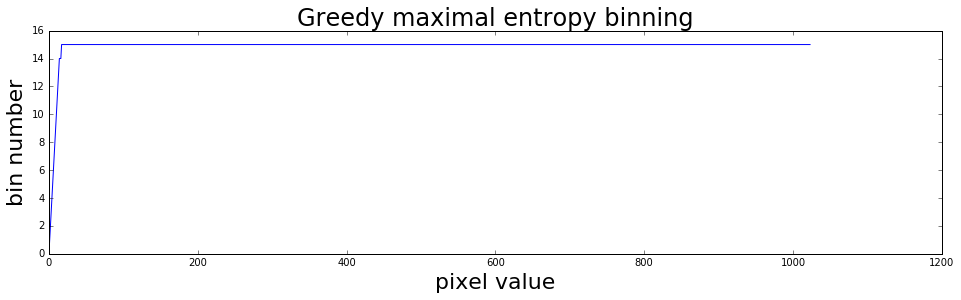

In [11]:
plt.figure(figsize=(16, 4))
plt.title('Greedy maximal entropy binning', fontsize=24)
plt.xlabel('pixel value', fontsize=22)
plt.ylabel('bin number', fontsize=22)
plt.plot(mapping)

### Robustness checks

Below we compare scores of the EM algorithm on two sets of image from the same run.

In [12]:
### binning function creates value histogram
### for each pixel
from crayimage.imgutils import binning

In [13]:
### First fold
counts = binning(run[::2], mapping)

### Second fold
counts2 = binning(run[1::2], mapping)

### one-class-EM algorithm

This algorithm assignes weights to each pixel. Weights represent similarity to local averaged by pixels distribution.

Thus if a pixel has a low weight then it is considerebly different from its neighbors hence might be considered as an outlier.

In [14]:
from crayimage.hotornot import *

To measure similarity (kernel) below we use laplacian kernel over Hellinger distance.
$$\mathrm{K}(h_1, h_2) = \exp(-\alpha \cdot \mathrm{Hellinger}(h_1, h_2))$$

where:
- $h_1$, $h_2$ - distributions of pixel values.

In [15]:
kernel = laplacian_kernel(Hellinger_distance(), alpha=2)
em = OneClassEm(kernel=kernel, max_iter=10, max_diff=None)

mask = em.hck(counts, window_x=128, window_y=128)

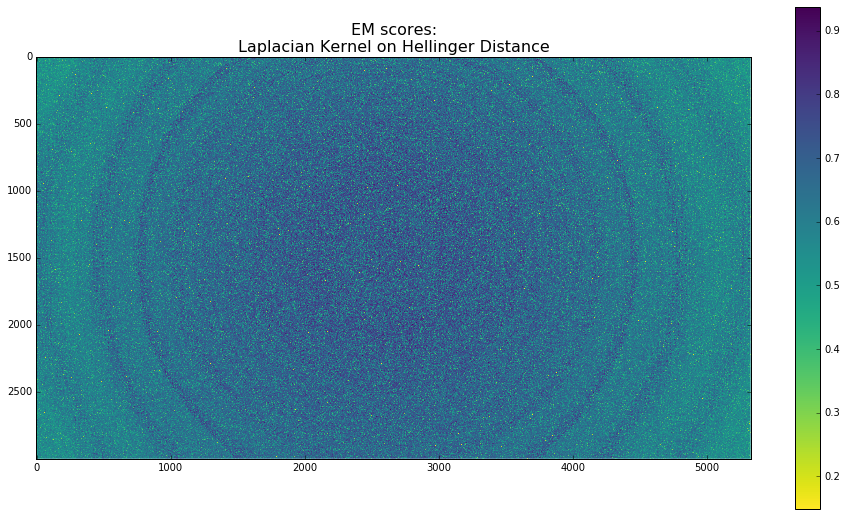

In [16]:
plt.figure(figsize=(16, 9))
plt.title("EM scores:\nLaplacian Kernel on Hellinger Distance", fontsize=16)
plt.imshow(mask[0, :, :], interpolation='None', cmap=plt.cm.viridis_r)
plt.colorbar()

A region zoomed, candidates for hot-pixels are circled.

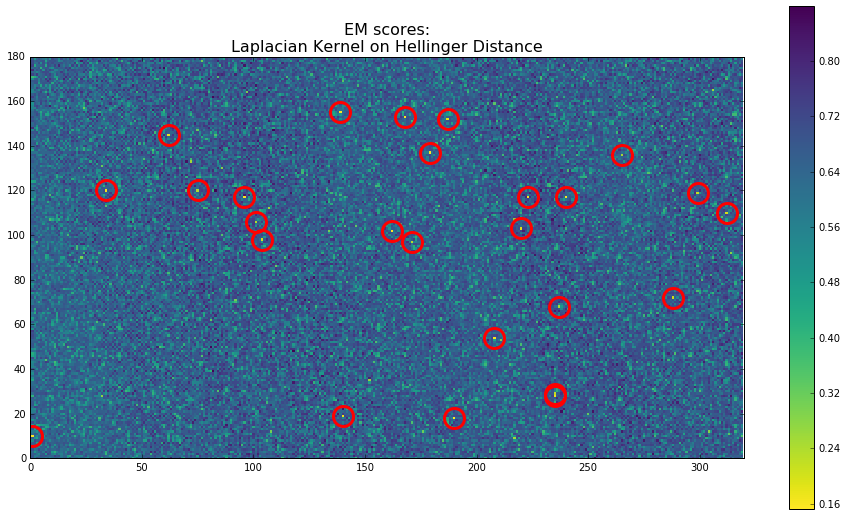

In [17]:
plt.figure(figsize=(16, 9))
plt.title("EM scores:\nLaplacian Kernel on Hellinger Distance", fontsize=16)
plt.imshow(mask[0, 1000:1180, 1000:1320], interpolation='None', cmap=plt.cm.viridis_r)
x, y = np.where(mask[0, 1000:1180, 1000:1320] < 0.25)
plt.plot(y, x, 'ro', fillstyle='none', lw= 3, markeredgewidth=3, ms= 20)
plt.xlim(0, 320)
plt.ylim(0, 180)
plt.colorbar()

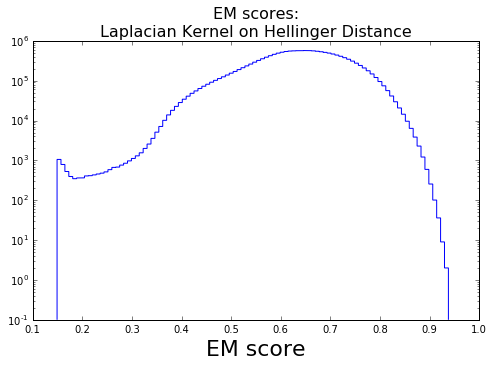

In [18]:
plt.figure(figsize=(8, 5))
plt.title("EM scores:\nLaplacian Kernel on Hellinger Distance", fontsize=16)
_ = plt.hist(mask.ravel(), histtype='step', bins=100, log=True)
plt.xlabel('EM score', fontsize=22)

In [19]:
mask2 = em.hck(counts2, window_x=64, window_y=64)

In [20]:
np.corrcoef(mask.ravel(), mask2.ravel())

array([[ 1.        ,  0.91625832],
       [ 0.91625832,  1.        ]])

Comparison of score for two folds.

__Note__ two clusters: the large one ('Ok' pixels) and hardly noticable one at left bottom corner (criminals).

(0, 1)

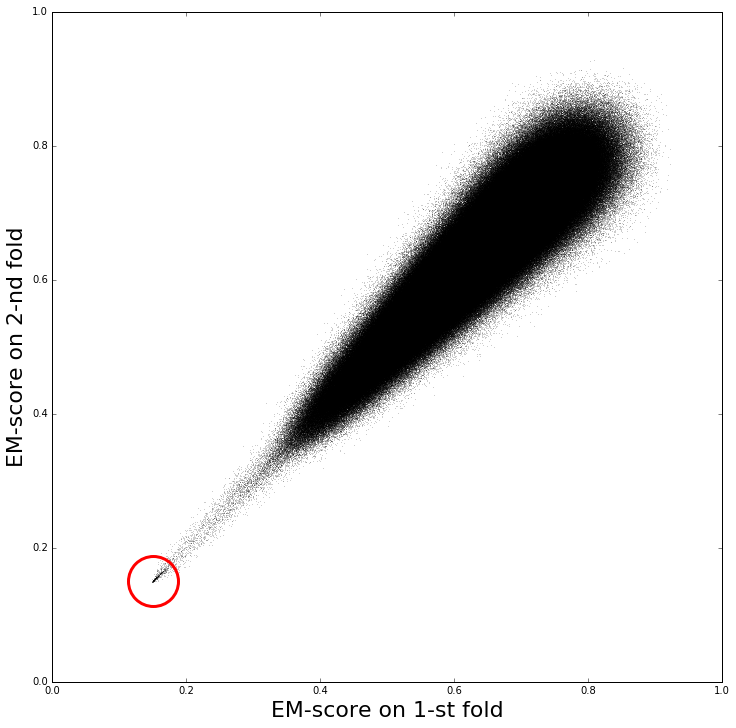

In [21]:
plt.figure(figsize=(12, 12))
_ = plt.scatter(mask.ravel()[::5], mask2.ravel()[::5], lw=0, s = 1, alpha=0.25, color='black')
plt.xlabel('EM-score on 1-st fold', fontsize=22)
plt.ylabel('EM-score on 2-nd fold', fontsize=22)
plt.plot([0.15], [0.15], 'ro', fillstyle='none', lw= 3, markeredgewidth=3, ms= 50)
plt.xlim([0, 1])
plt.ylim([0, 1])

Examples of pixel value distributions for different EM-scores.

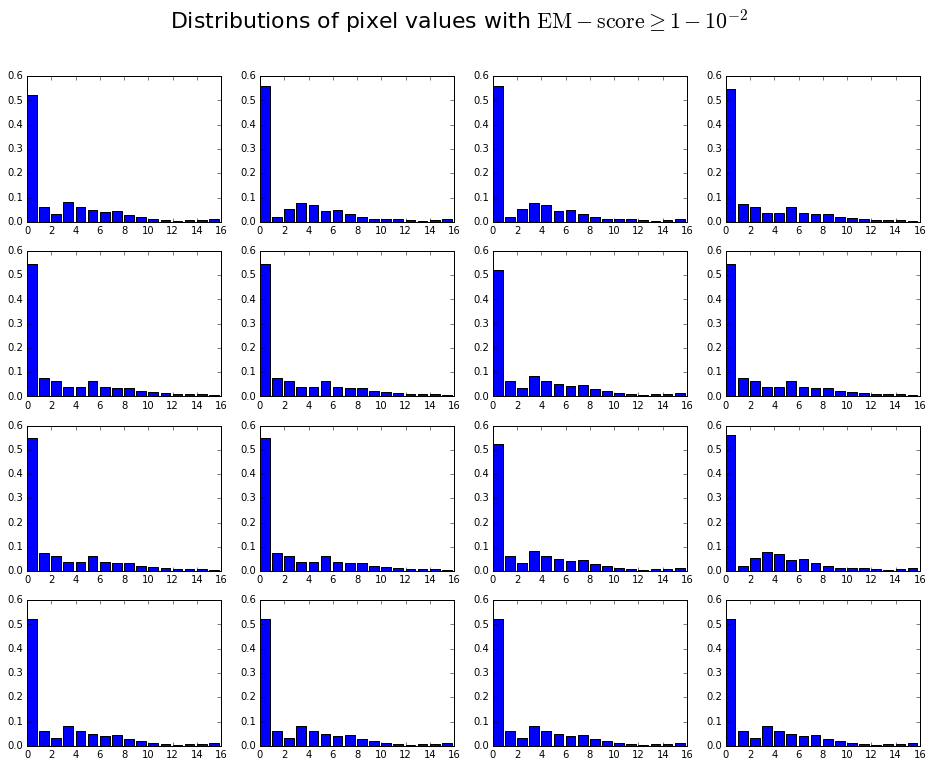

In [22]:
_, ix, iy = np.where(mask >= np.max(mask) - 1.0e-2)

plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
for i, k in enumerate(np.random.choice(ix.shape[0], size=16)):
    plt.subplot(4, 4, i + 1)
    plt.bar(np.arange(counts.shape[-1]), counts[0, ix[k], iy[k]] / float(np.sum(counts[0, ix[k], iy[k]])) )
    
plt.suptitle('Distributions of pixel values with $\mathrm{EM-score} \geq 1 - 10^{-2}$', fontsize=22)
plt.show()

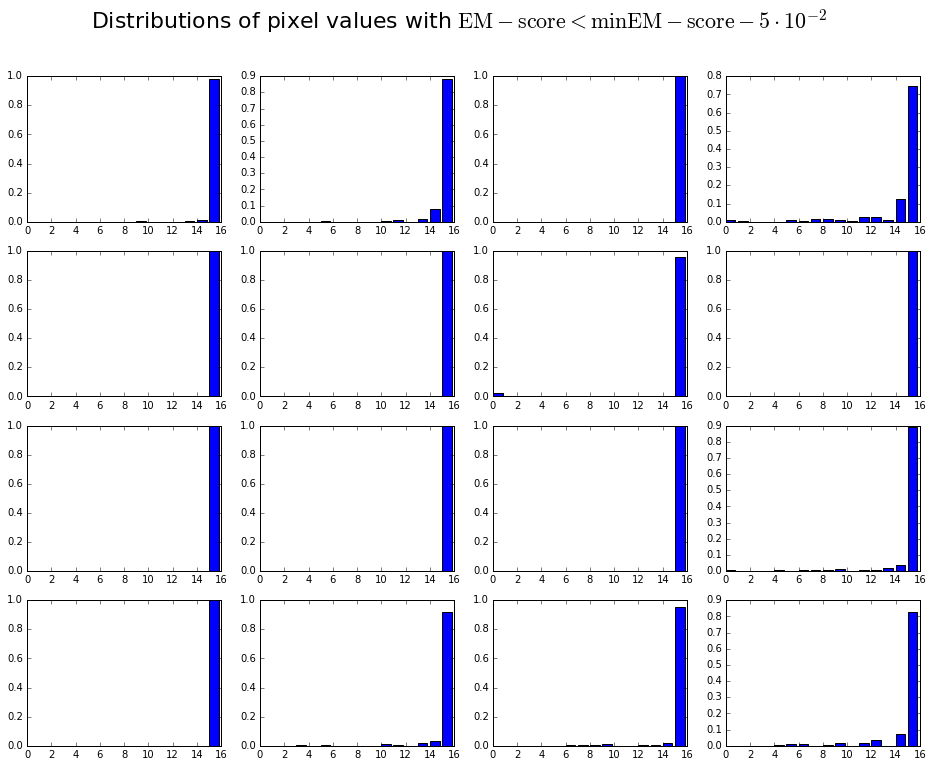

In [23]:
_, ix, iy = np.where(mask < np.min(mask) + 5.0e-2)

plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
for i, k in enumerate(np.random.choice(ix.shape[0], size=16)):
    plt.subplot(4, 4, i + 1)
    plt.bar(np.arange(counts.shape[-1]), counts[0, ix[k], iy[k]] / float(np.sum(counts[0, ix[k], iy[k]])) )
    
plt.suptitle(
    r'Distributions of pixel values with $\mathrm{EM-score} < \min{\mathrm{EM-score}} - 5 \cdot 10^{-2}$',
    fontsize=22
)
plt.show()

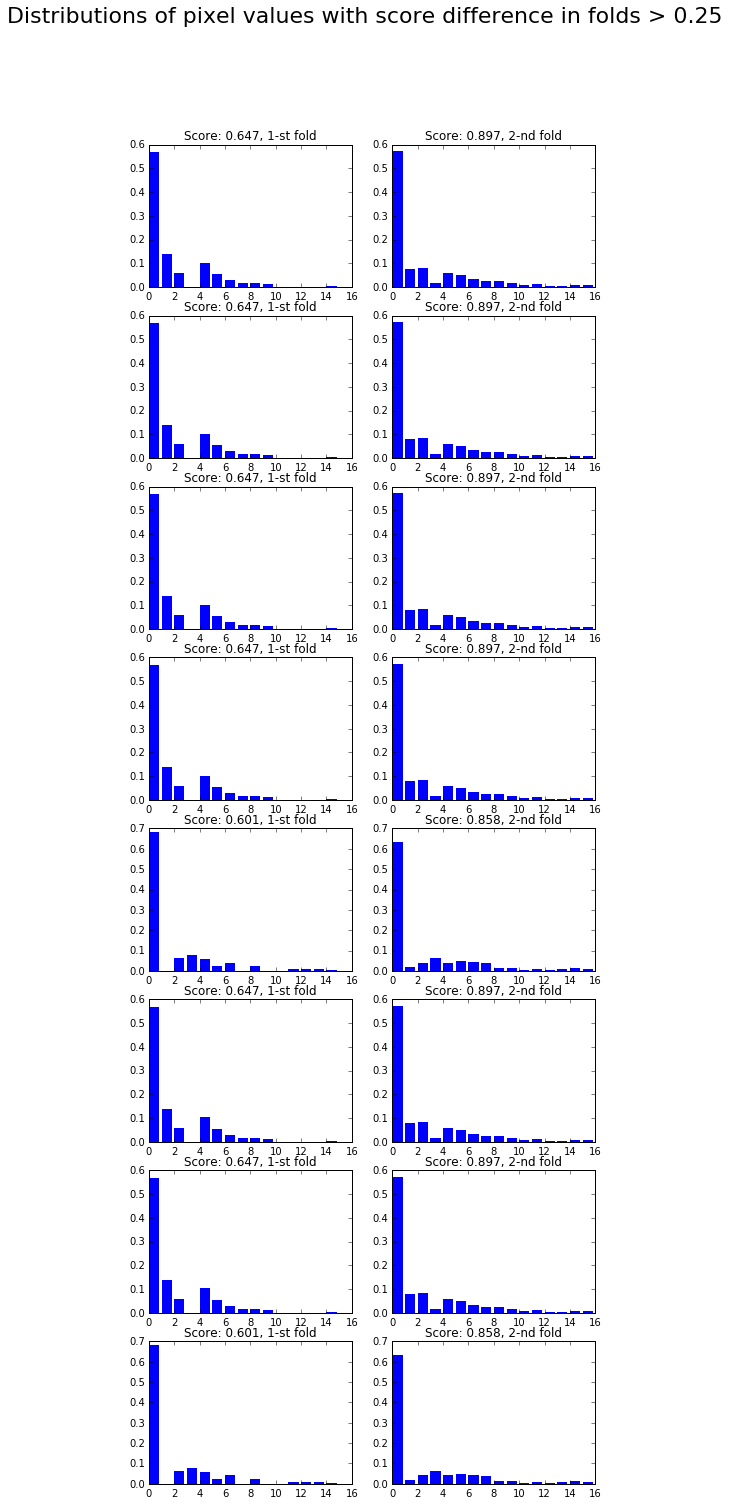

In [24]:
_, ix, iy = np.where(np.abs(mask - mask2) > 0.25)

plt.subplots(nrows=8, ncols=2, figsize=(8, 24))

for i, k in enumerate(np.random.choice(ix.shape[0], size=8)):
    plt.subplot(8, 2, 2 * i + 1)
    plt.title('Score: %.3f, 1-st fold' % mask[0, ix[k], iy[k]])
    plt.bar(np.arange(counts.shape[-1]), counts[0, ix[k], iy[k]] / float(np.sum(counts[0, ix[k], iy[k]])), lw = 0)
    
    plt.subplot(8, 2, 2 * i + 2)
    plt.title('Score: %.3f, 2-nd fold' % mask2[0, ix[k], iy[k]])
    plt.bar(np.arange(counts.shape[-1]), counts2[0, ix[k], iy[k]] / float(np.sum(counts2[0, ix[k], iy[k]])), lw = 0)
    
plt.suptitle('Distributions of pixel values with score difference in folds > 0.25', fontsize=22)
plt.show()

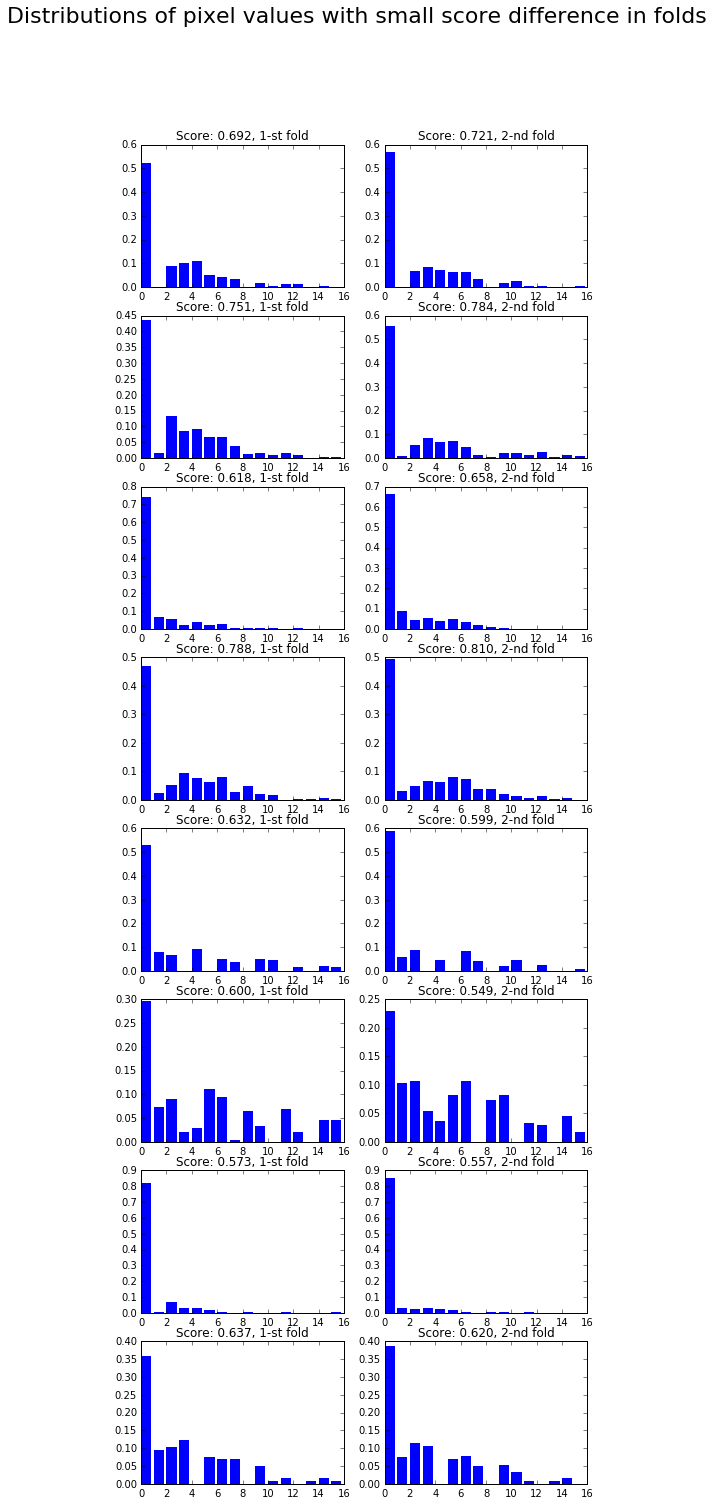

In [25]:
_, ix, iy = np.where(np.abs(mask - mask2) < 0.1)

plt.subplots(nrows=8, ncols=2, figsize=(8, 24))

for i, k in enumerate(np.random.choice(ix.shape[0], size=8)):
    plt.subplot(8, 2, 2 * i + 1)
    plt.title('Score: %.3f, 1-st fold' % mask[0, ix[k], iy[k]])
    plt.bar(np.arange(counts.shape[-1]), counts[0, ix[k], iy[k]] / float(np.sum(counts[0, ix[k], iy[k]])), lw = 0)
    
    plt.subplot(8, 2, 2 * i + 2)
    plt.title('Score: %.3f, 2-nd fold' % mask2[0, ix[k], iy[k]])
    plt.bar(np.arange(counts.shape[-1]), counts2[0, ix[k], iy[k]] / float(np.sum(counts2[0, ix[k], iy[k]])), lw = 0)
    
plt.suptitle('Distributions of pixel values with small score difference in folds', fontsize=22)
plt.show()

### Comparison between runs

In [26]:
counts.fill(0)
count_cal = binning(runs['cal'], mapping, counts=counts)

In [27]:
counts2.fill(0)
counts_Ra = binning(runs['Ra226'], mapping, counts=counts2)

In [28]:
counts_Co = binning(runs['Co60'], mapping, counts=None)

In [29]:
%%time

mask_cal = em.hck(count_cal, window_x=128, window_y=128)

CPU times: user 32.8 s, sys: 13.1 ms, total: 32.9 s
Wall time: 32.9 s


In [30]:
%%time

mask_Ra = em.hck(counts_Ra, window_x=128, window_y=128)

CPU times: user 32.7 s, sys: 17 ms, total: 32.7 s
Wall time: 32.7 s


In [31]:
%%time

mask_Co = em.hck(counts_Co, window_x=128, window_y=128)

CPU times: user 33.1 s, sys: 21.1 ms, total: 33.1 s
Wall time: 33.1 s


In [32]:
counts_sample = counts_Co[:, 1024:(1024 + 128), 1024:(1024 + 128)].copy()
print counts_sample.shape

(1, 128, 128, 16)


In [33]:
m0 = em.hck(counts_sample)

In [34]:
counts_sample[0, 0, 0, 0] -= 5
counts_sample[0, 0, 0, -1] += 5

In [35]:
m1 = em.hck(counts_sample)

In [36]:
print m0[0, 0, 0], m1[0, 0, 0]

0.488386 0.48214


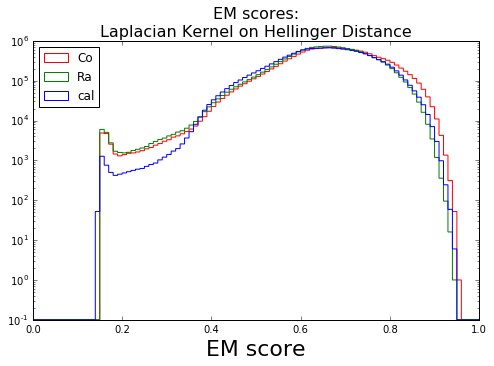

In [37]:
plt.figure(figsize=(8, 5))
plt.title("EM scores:\nLaplacian Kernel on Hellinger Distance", fontsize=16)
_ = plt.hist([
    mask_cal.ravel(),
    mask_Ra.ravel(),
    mask_Co.ravel(),
], range=[0, 1], histtype='step', bins=100, log=True, label=['cal', 'Ra', 'Co'])
plt.xlabel('EM score', fontsize=22)
plt.legend(loc='upper left')

(0, 1)

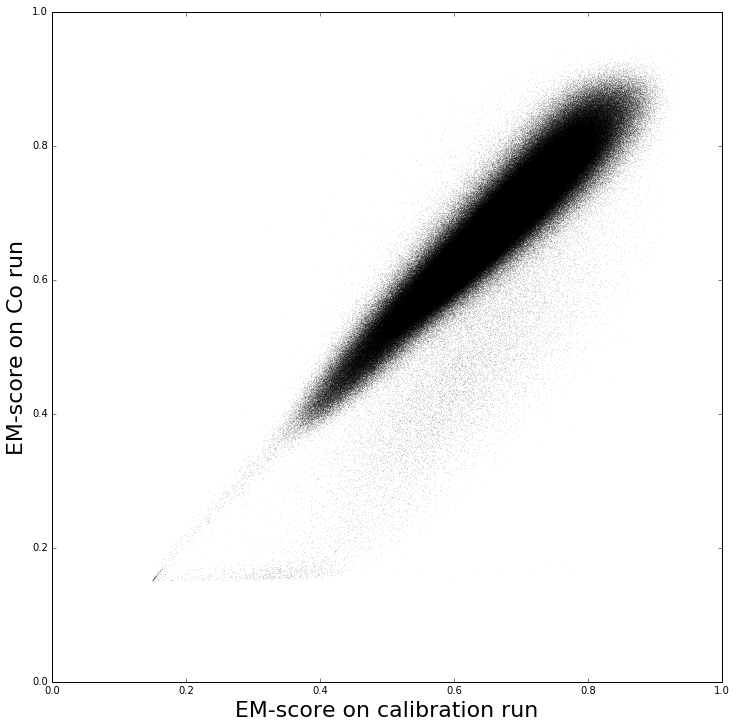

In [38]:
plt.figure(figsize=(12, 12))
_ = plt.scatter(mask_cal.ravel()[::10], mask_Co.ravel()[::10], lw=0, s = 1, alpha=0.1, color='black')
plt.xlabel('EM-score on calibration run', fontsize=22)
plt.ylabel('EM-score on Co run', fontsize=22)
plt.xlim([0, 1])
plt.ylim([0, 1])

(0, 1)

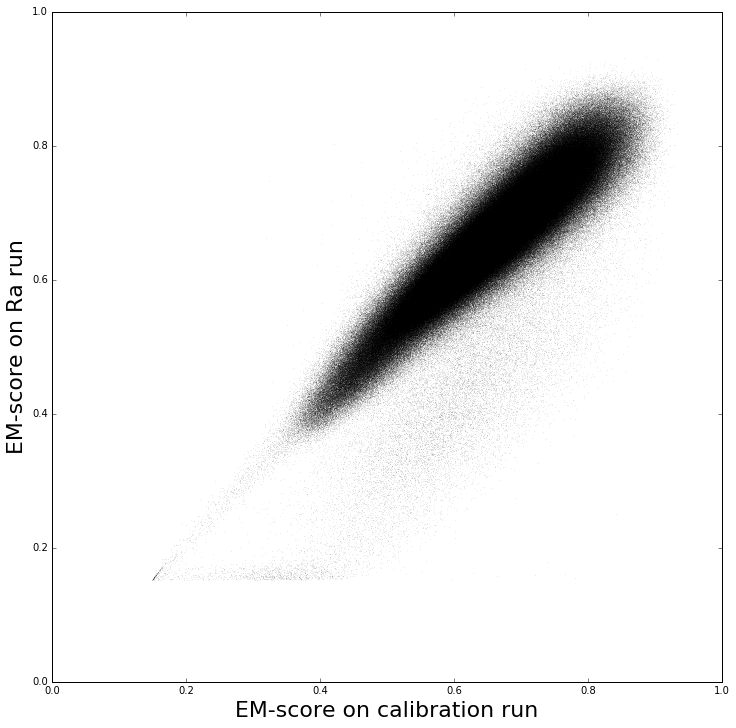

In [39]:
plt.figure(figsize=(12, 12))
_ = plt.scatter(mask_cal.ravel()[::10], mask_Ra.ravel()[::10], lw=0, s = 1, alpha=0.1, color='black')
plt.xlabel('EM-score on calibration run', fontsize=22)
plt.ylabel('EM-score on Ra run', fontsize=22)
plt.xlim([0, 1])
plt.ylim([0, 1])

(0, 1)

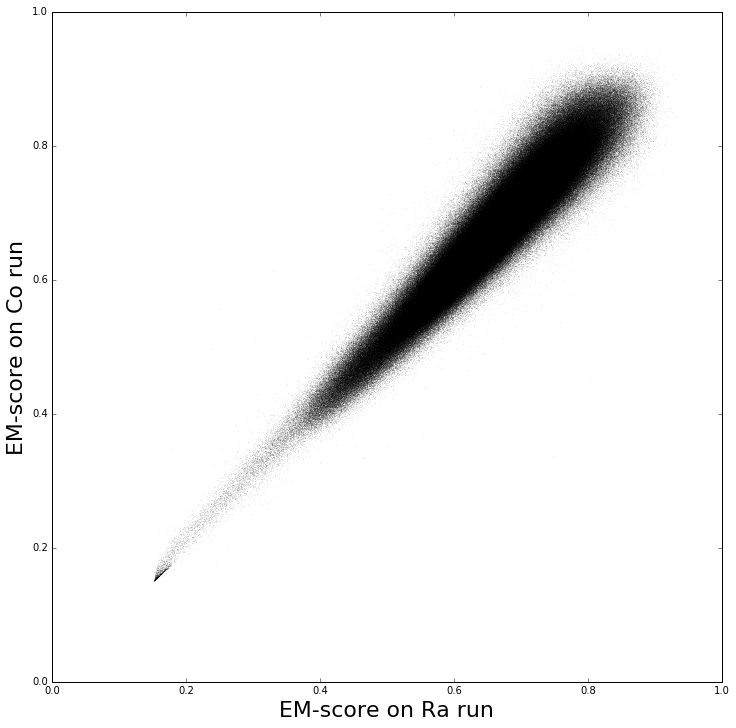

In [40]:
plt.figure(figsize=(12, 12))
_ = plt.scatter(mask_Ra.ravel()[::10], mask_Co.ravel()[::10], lw=0, s = 1, alpha=0.1, color='black')
plt.xlabel('EM-score on Ra run', fontsize=22)
plt.ylabel('EM-score on Co run', fontsize=22)
plt.xlim([0, 1])
plt.ylim([0, 1])

Comparing masks

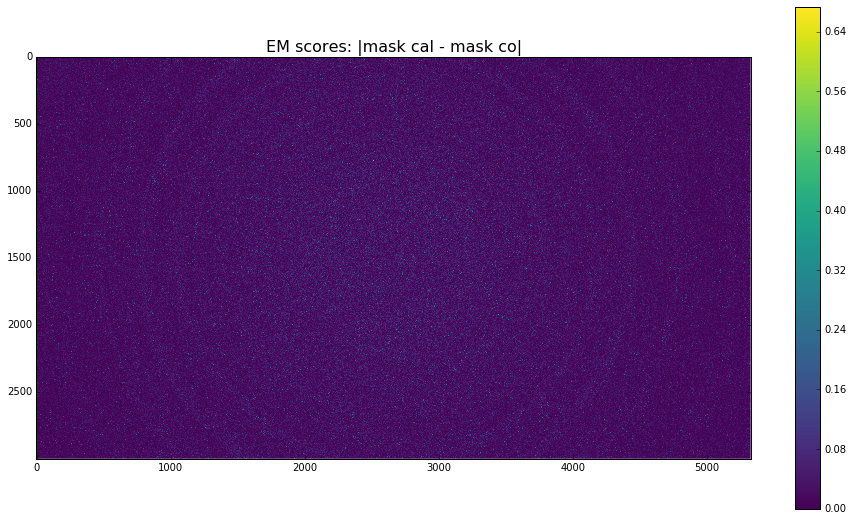

In [41]:
plt.figure(figsize=(16, 9))
plt.title("EM scores: |mask cal - mask co|", fontsize=16)
plt.imshow(np.abs(mask_cal[0] - mask_Co[0]), interpolation='None', cmap=plt.cm.viridis)
plt.colorbar()

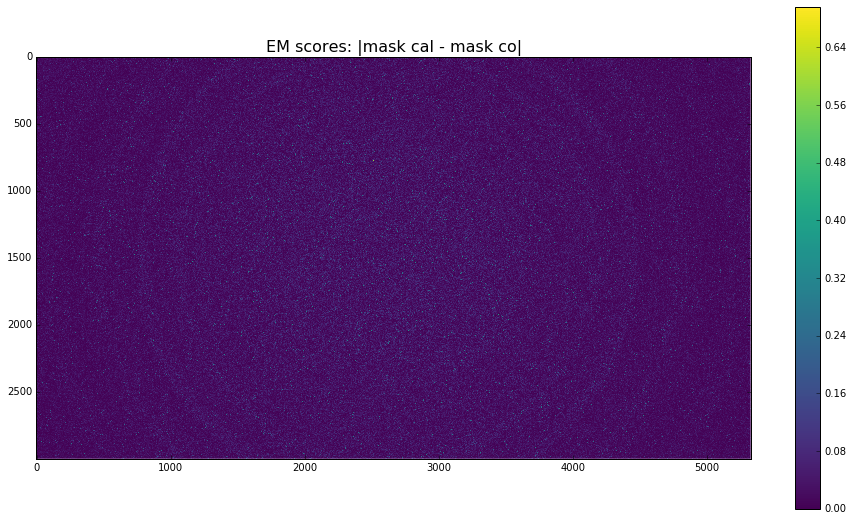

In [42]:
plt.figure(figsize=(16, 9))
plt.title("EM scores: |mask cal - mask co|", fontsize=16)
plt.imshow(np.abs(mask_cal[0] - mask_Ra[0]), interpolation='None', cmap=plt.cm.viridis)
plt.colorbar()

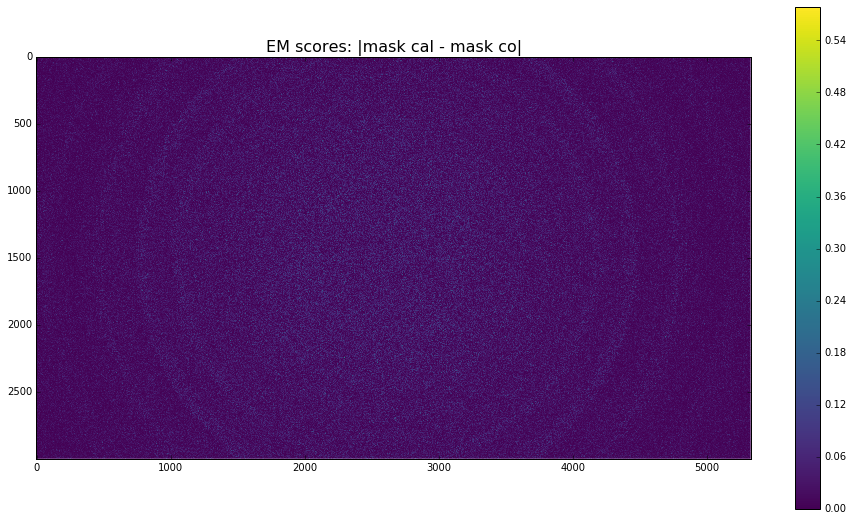

In [43]:
plt.figure(figsize=(16, 9))
plt.title("EM scores: |mask cal - mask co|", fontsize=16)
plt.imshow(np.abs(mask_Co[0] - mask_Ra[0]), interpolation='None', cmap=plt.cm.viridis)
plt.colorbar()

In [44]:
thr = np.percentile(mask_Co.ravel(), q=0.25)

### Mask for Co60 run

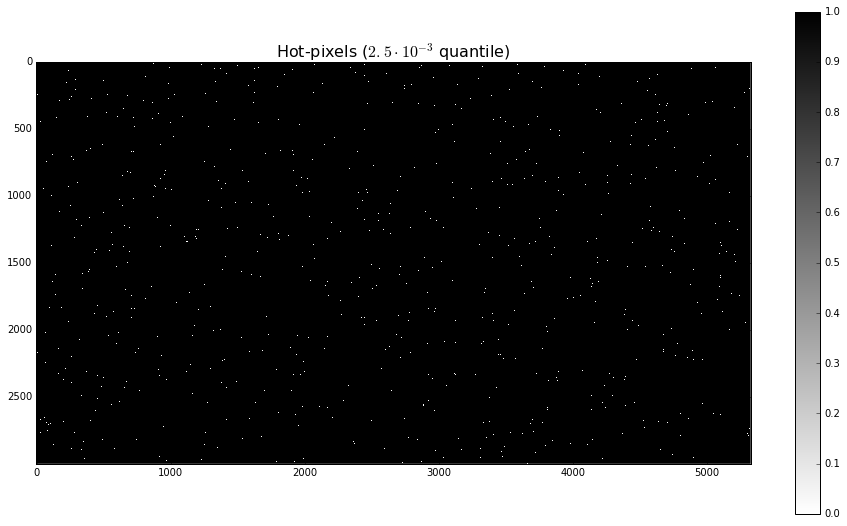

In [45]:
plt.figure(figsize=(16, 9))
plt.title("Hot-pixels ($2.5 \cdot 10^{-3}$ quantile)", fontsize=16)
plt.imshow(mask_Co[0] > thr, interpolation='None', cmap=plt.cm.gray_r)
plt.colorbar()

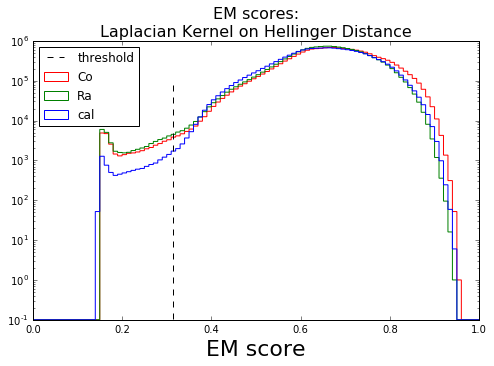

In [46]:
plt.figure(figsize=(8, 5))
plt.title("EM scores:\nLaplacian Kernel on Hellinger Distance", fontsize=16)
_ = plt.hist([
    mask_cal.ravel(),
    mask_Ra.ravel(),
    mask_Co.ravel(),
], range=[0, 1], histtype='step', bins=100, log=True, label=['cal', 'Ra', 'Co'])
plt.plot([thr, thr], [0, 10 ** 5], '--', color='black', label='threshold')
plt.xlabel('EM score', fontsize=22)
plt.legend(loc='upper left')

In [47]:
mean_filter = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
], dtype='float32')

mean_filter /= np.sum(mean_filter)

In [48]:
img = runs['Ra226'].get_img(0)

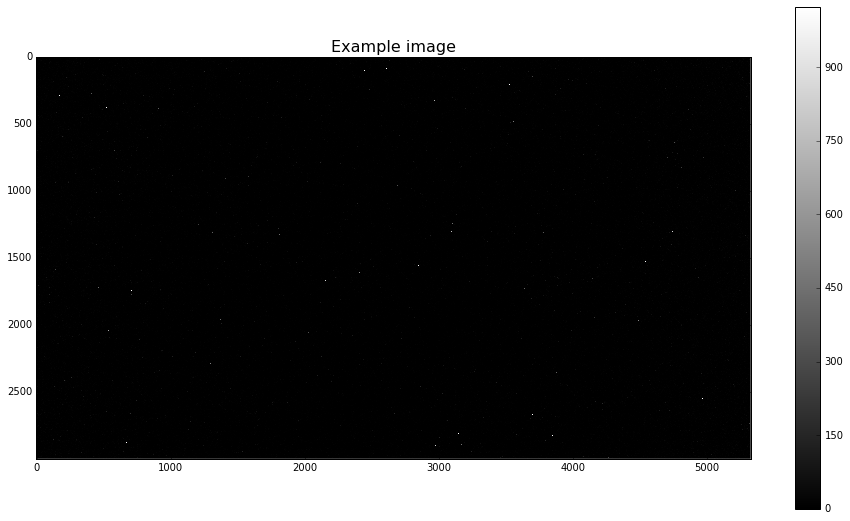

In [49]:
plt.figure(figsize=(16, 9))
plt.title("Example image", fontsize=16)
plt.imshow(img[0], interpolation='None', cmap=plt.cm.gray)
plt.colorbar()

### Masking

The simpliest way of masking hot pixels is to replace their values with avarage of neighbors' values.

In [50]:
from scipy.signal import convolve2d

In [51]:
conved = convolve2d(img[0], mean_filter, mode='same', boundary='symm').astype('uint16')

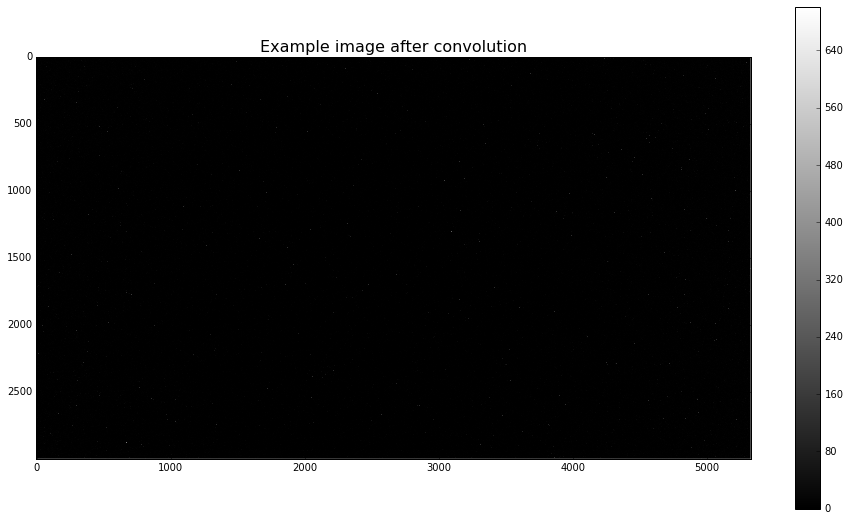

In [60]:
plt.figure(figsize=(16, 9))
plt.title("Example image after convolution", fontsize=16)
plt.imshow(conved, interpolation='None', cmap=plt.cm.gray)
plt.colorbar()

In [61]:
masked = np.where(mask_cal > thr, img, conved[None, :, :])

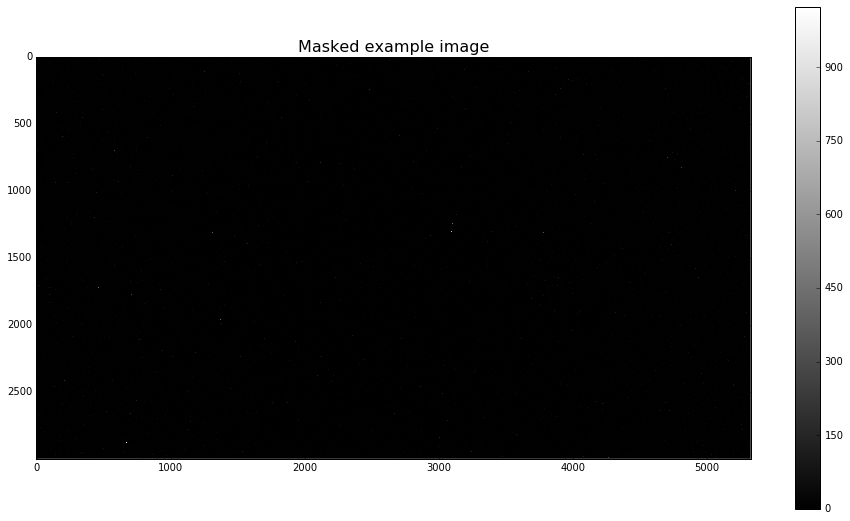

In [62]:
plt.figure(figsize=(16, 9))
plt.title("Masked example image", fontsize=16)
plt.imshow(masked[0], interpolation='None', cmap=plt.cm.gray)
plt.colorbar()

In [63]:
from crayimage.imgutils import slice, flatten

In [64]:
s1 = flatten(slice(img, window=32, step=16))

In [65]:
s2 = flatten(slice(masked, window=32, step=16))

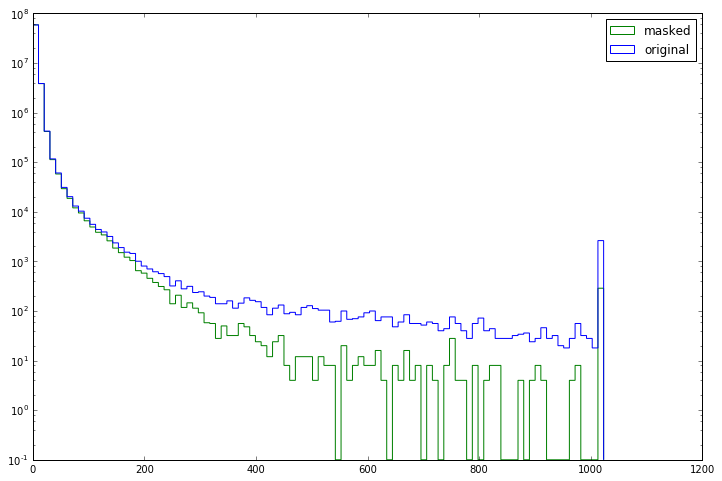

In [66]:
plt.figure(figsize=(12, 8))
_ = plt.hist([
    s1.ravel(),
    s2.ravel()
], histtype='step', bins=100, log=True, label=['original', 'masked'])
plt.legend()

### 'Before' and 'after'

__Note that some of selected patches can be particle traces (espicially these with no difference between original and masked versions):__ patches are selected only to have high pixel values which is not necessarily a hot-pixel.

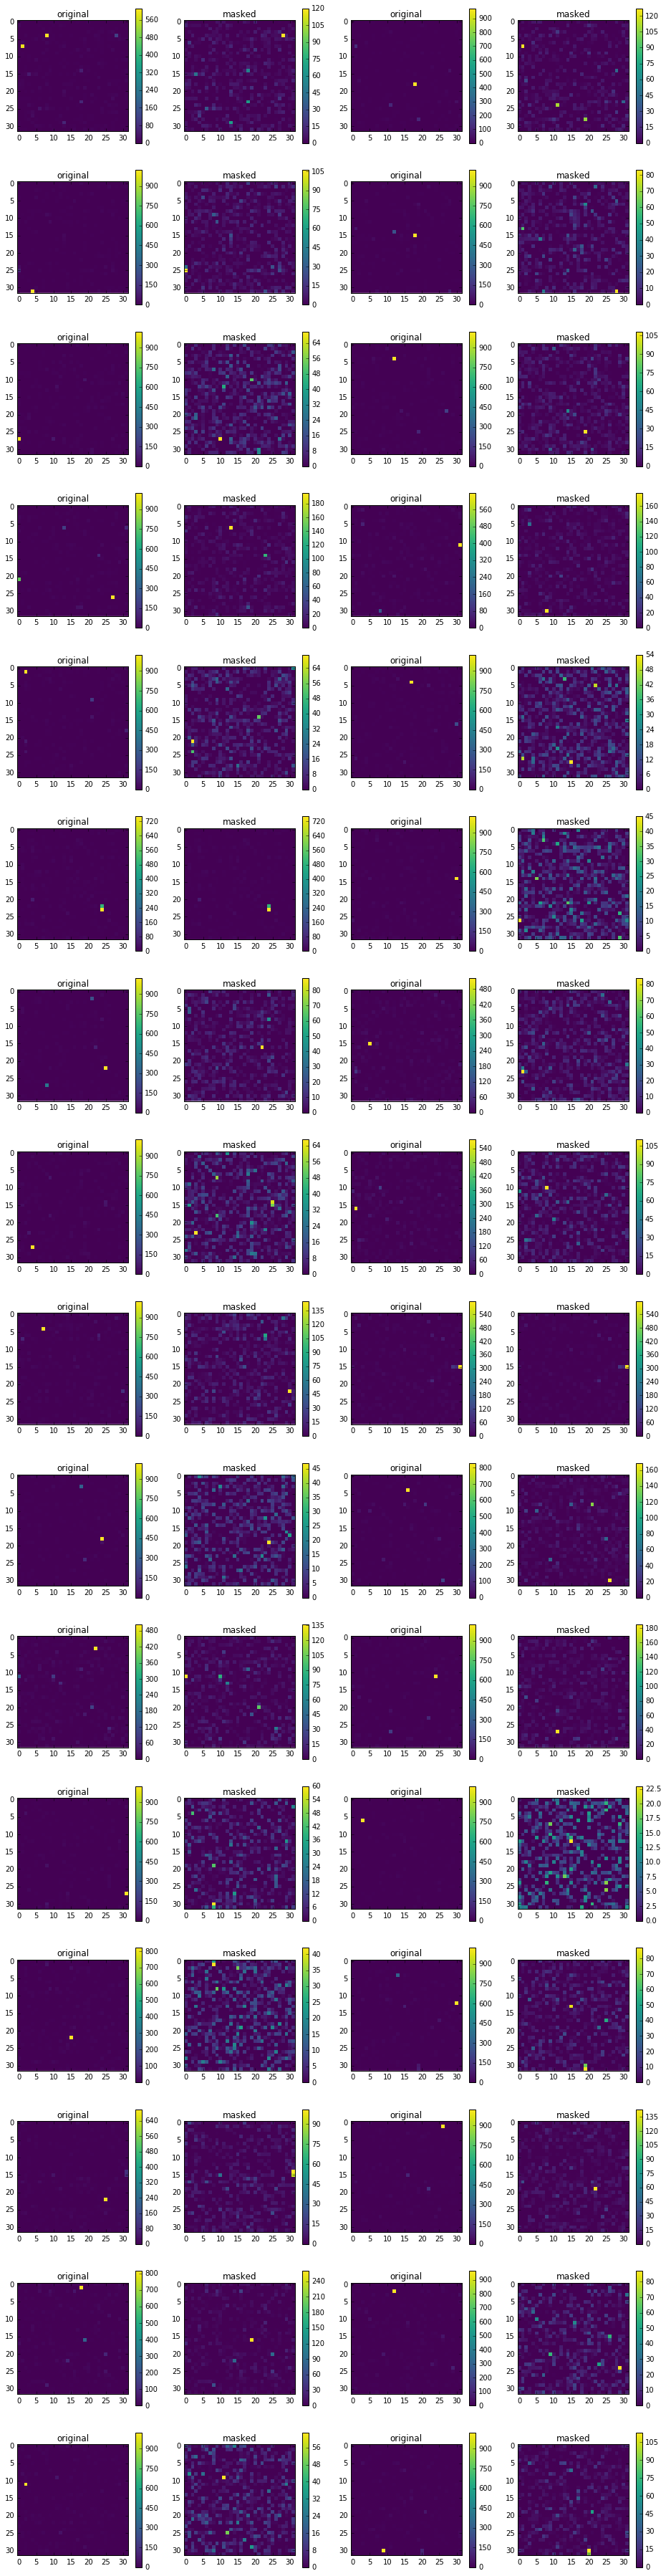

In [67]:
ix = np.where(np.max(s1, axis=(1, 2, 3)) > 500)[0]

n= 16
plt.subplots(nrows=n, ncols=4, figsize=(16, 4 * n))

for i, k in enumerate(np.random.choice(ix.shape[0], size=n * 2)):
    m = np.max([np.max(s1[ix[k], 0]), np.max(s2[ix[k], 0])])

    plt.subplot(n, 4, 2 * i + 1)
    plt.title('original')
    plt.imshow(s1[ix[k], 0], interpolation='none', cmap=plt.cm.viridis)
    plt.colorbar()
    
    plt.subplot(n, 4, 2 * i + 2)
    plt.title('masked')
    plt.imshow(s2[ix[k], 0], interpolation='none', cmap=plt.cm.viridis)
    plt.colorbar()
    
plt.show()

### Performing masking

In [68]:
%%sh

mkdir -p /mnt/crayfis/data/rawcam_clean/

In [69]:
import itertools
import os
import os.path as osp
import shutil as sh

from scipy.signal import convolve2d

mean_filter = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
], dtype='float32')

mean_filter /= np.sum(mean_filter)

In [70]:
def mask_image(img, mask, thrs):
    for channel in range(img.shape[0]):
        conved = convolve2d(img[channel], mean_filter, mode='same', boundary='symm').astype(img.dtype)
        img[channel] = np.where(mask[channel] > thrs[channel], img[channel], conved)
    return img

In [ ]:
def mask_run(run, output, mask, thr=None, q=1.0e-3):
    thr = thr or np.percentile(mask.reshape(mask.shape[0], -1), q=q * 100.0, axis=1)

    for img, path in itertools.izip(run, run.paths):
        mask_image(img, mask, thr)
        
        try:
            os.makedirs(osp.join(
                output, osp.dirname(path)
            ))
        except:
            pass
        
        out_path = osp.join(output, path)
        np.savez_compressed(out_path, img)

In [ ]:
mask_run(runs['Co60'], output = '/mnt/crayfis/data/rawcam_clean/', mask=mask_Co)

In [ ]:
mask_run(runs['Ra226'], output = '/mnt/crayfis/data/rawcam_clean/', mask=mask_Co)

In [ ]:
mask_run(runs['cal'], output = '/mnt/crayfis/data/rawcam_clean/', mask=mask_Co)

In [ ]:
mask_run(runs['Cs137'], output = '/mnt/crayfis/data/rawcam_clean/', mask=mask_Co)